# Breast Cancer Diagnostic: 
[Source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic))

## About Dataset:
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.

### Features:
1) ID number

2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)

b) texture (standard deviation of gray-scale values)

c) perimeter

d) area

e) smoothness (local variation in radius lengths)

f) compactness (perimeter^2 / area - 1.0)

g) concavity (severity of concave portions of the contour)

h) concave points (number of concave portions of the contour)

i) symmetry

j) fractal dimension ("coastline approximation" - 1)


The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features. For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant




## Loading Libraries and Data:

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plt.rcParams['axes.grid'] = False

%matplotlib inline

### Configs:

In [2]:
DATA_DIR = '../data/'

In [3]:
df = pd.read_csv(DATA_DIR+ "data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.shape

(569, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

#### Notes:

* we don't need ID column for analysis.
* We have a column "Unamed" contains only null values.

In [7]:
# make a copy of data
dfc = df.copy()

In [8]:
# separate target column
target = dfc.diagnosis

In [9]:
# drop unnecessary columns
drop_cols = ['id', 'Unnamed: 32', 'diagnosis']
dfc = dfc.drop(columns = drop_cols)
# check
dfc.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

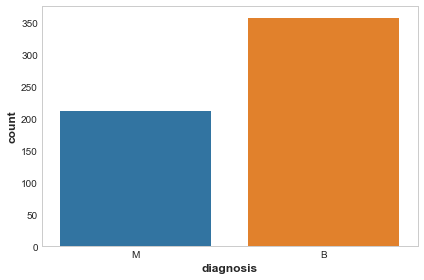

In [10]:
sns.countplot(target);

In [11]:
B, M= target.value_counts()
print(f"Count of benign cases: {B}")
print(f"Count of malignant cases: {M}")

Count of benign cases: 357
Count of malignant cases: 212


In [12]:
dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension_mean,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


#### Notes:

* Some features like: _"area_mean"_, _"area_worst"_.. are on different scale.

In [13]:
# Standardizing Data
dfc_std = (dfc - dfc.mean()) / dfc.std()

In [14]:
data = pd.concat([target, dfc_std.iloc[:, 0:10]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

In [15]:
data

,diagnosis,features,value
0,M,radius_mean,1.096100
1,M,radius_mean,1.828212
2,M,radius_mean,1.578499
3,M,radius_mean,-0.768233
4,M,radius_mean,1.748758
...,...,...,...
5685,M,fractal_dimension_mean,-0.930209
5686,M,fractal_dimension_mean,-1.057681
5687,M,fractal_dimension_mean,-0.894800
5688,M,fractal_dimension_mean,1.042778


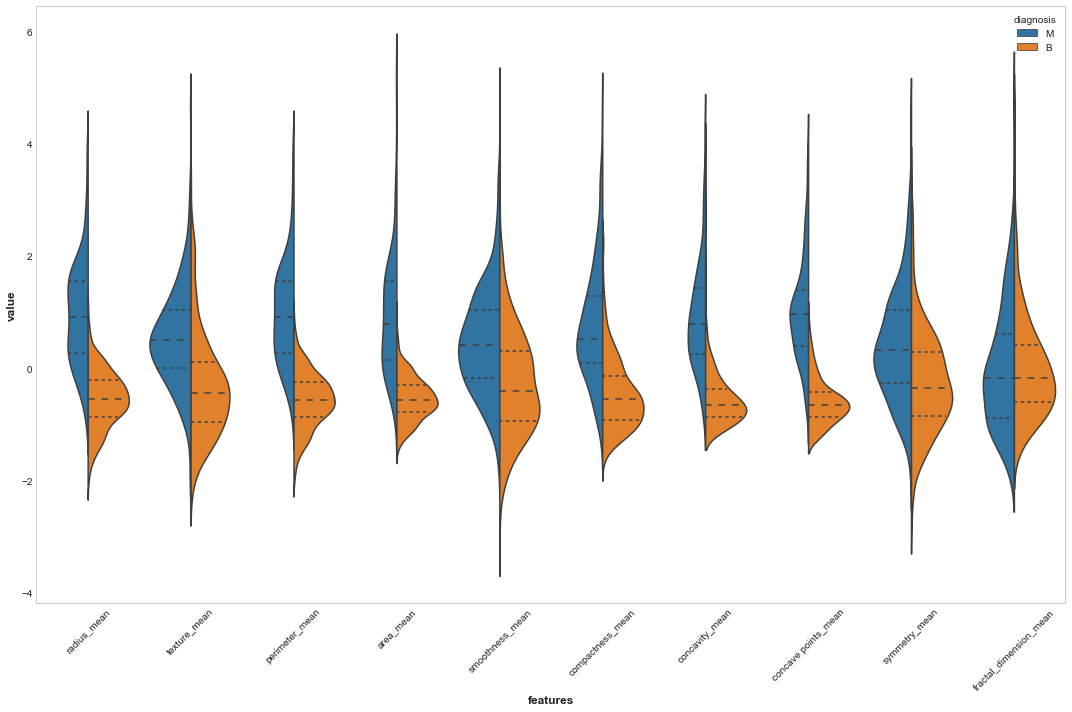

In [16]:
plt.figure(figsize= (15, 10))
sns.violinplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True, inner = 'quartile')
plt.xticks(rotation = 45);

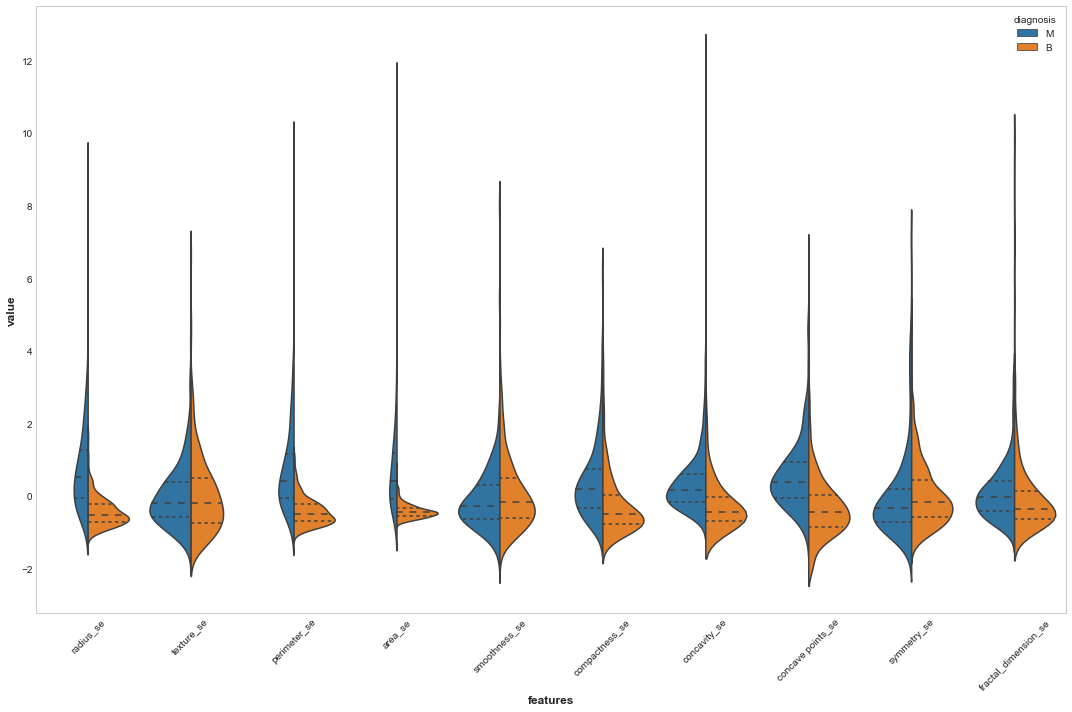

In [17]:
data = pd.concat([target, dfc_std.iloc[:, 10:20]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

plt.figure(figsize= (15, 10))
sns.violinplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True, inner = 'quartile')
plt.xticks(rotation = 45);

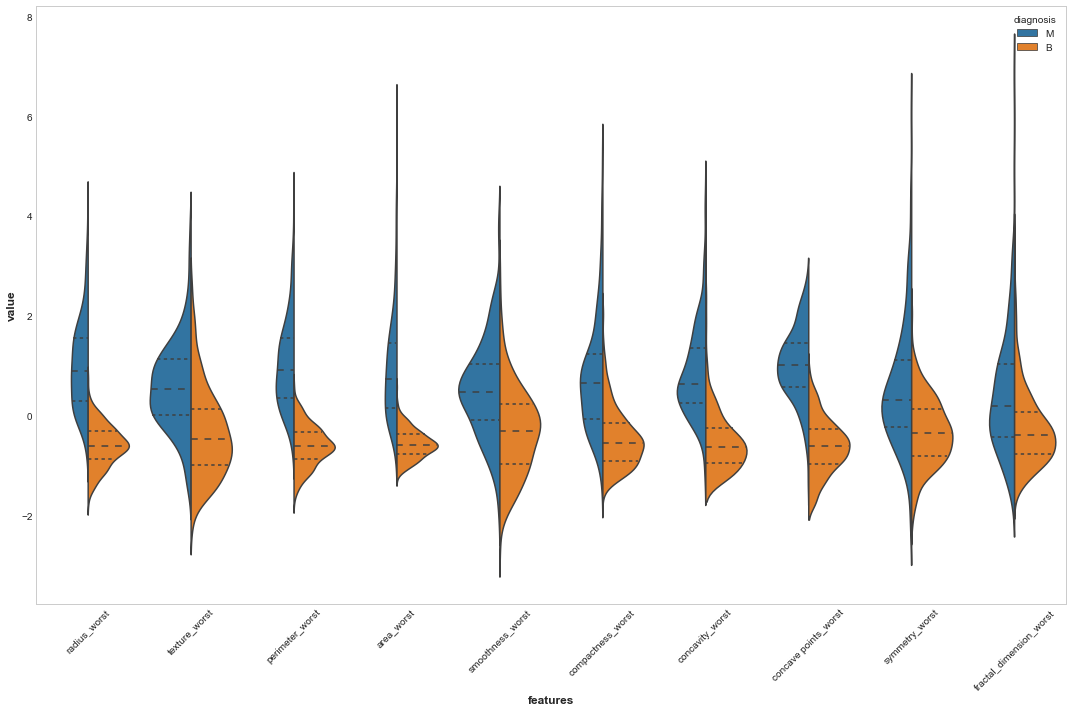

In [18]:
data = pd.concat([target, dfc_std.iloc[:, 20:]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

plt.figure(figsize= (15, 10))
sns.violinplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True, inner = 'quartile')
plt.xticks(rotation = 45);

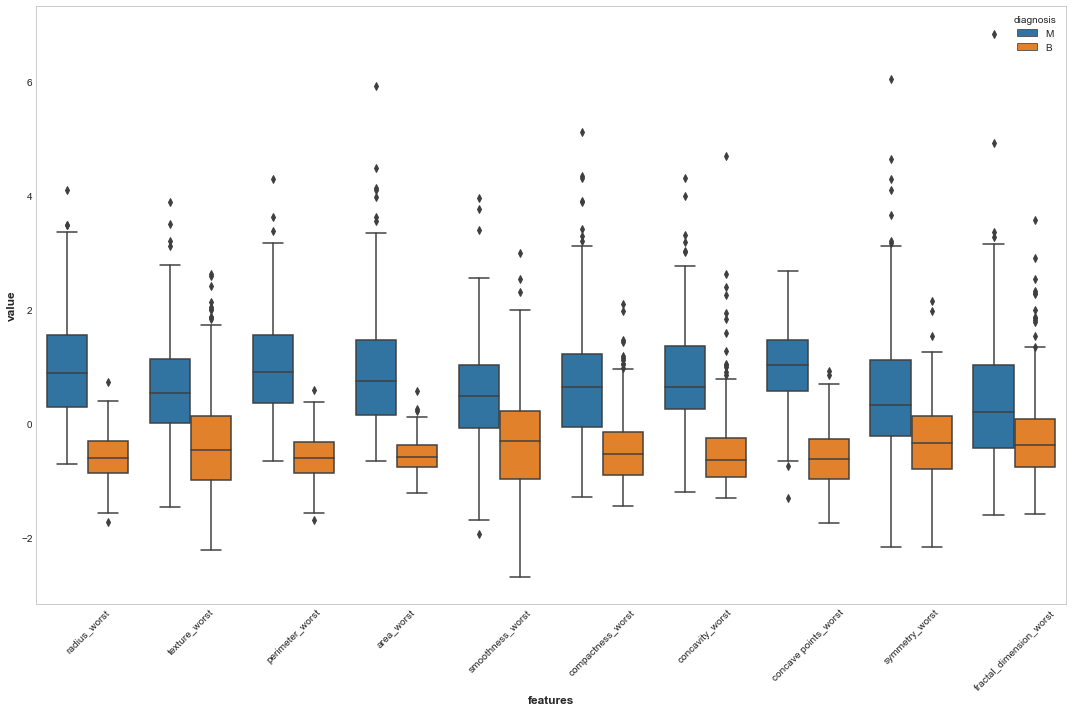

In [19]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'features', y = 'value', hue = 'diagnosis', data = data)
plt.xticks(rotation = 45);

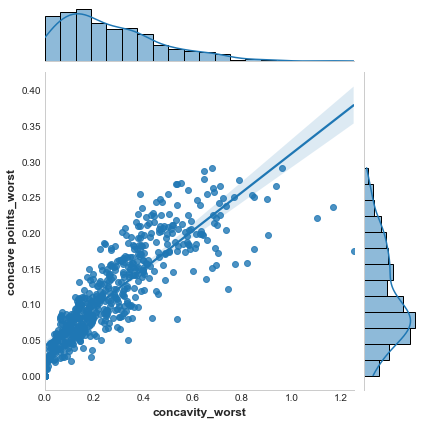

In [20]:
sns.jointplot(dfc.loc[:, 'concavity_worst'],
             dfc.loc[:, 'concave points_worst'],
             kind = 'reg');

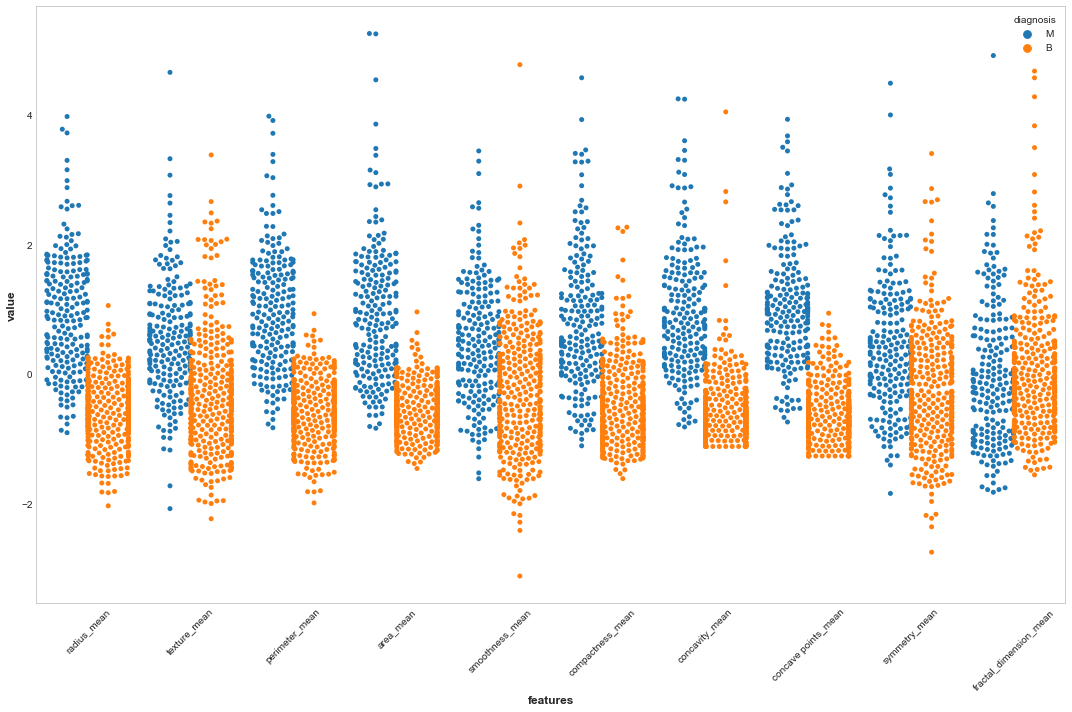

In [21]:
data = pd.concat([target, dfc_std.iloc[:, 0:10]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

plt.figure(figsize= (15, 10))
sns.swarmplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True)
plt.xticks(rotation = 45);

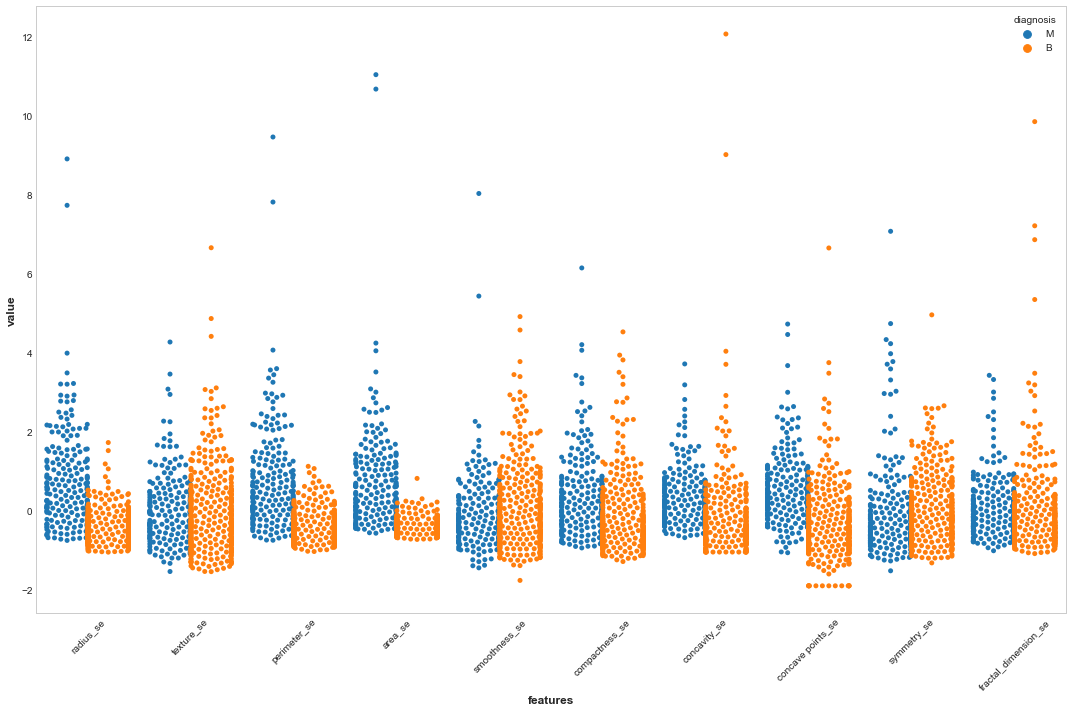

In [22]:
data = pd.concat([target, dfc_std.iloc[:, 10:20]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

plt.figure(figsize= (15, 10))
sns.swarmplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True)
plt.xticks(rotation = 45);

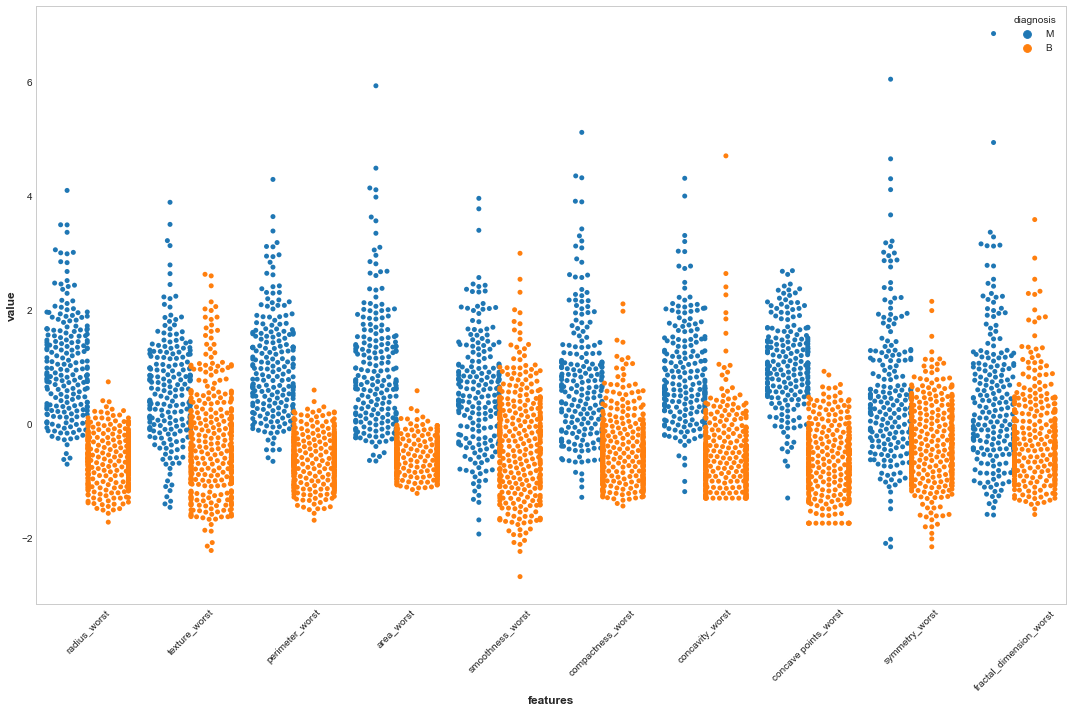

In [23]:
data = pd.concat([target, dfc_std.iloc[:, 20:]], axis = 1)
data = pd.melt(data, id_vars= 'diagnosis', var_name= 'features', 
              value_name = 'value')

plt.figure(figsize= (15, 10))
sns.swarmplot(x= 'features', y = 'value', hue = 'diagnosis', data = data, split = True)
plt.xticks(rotation = 45);

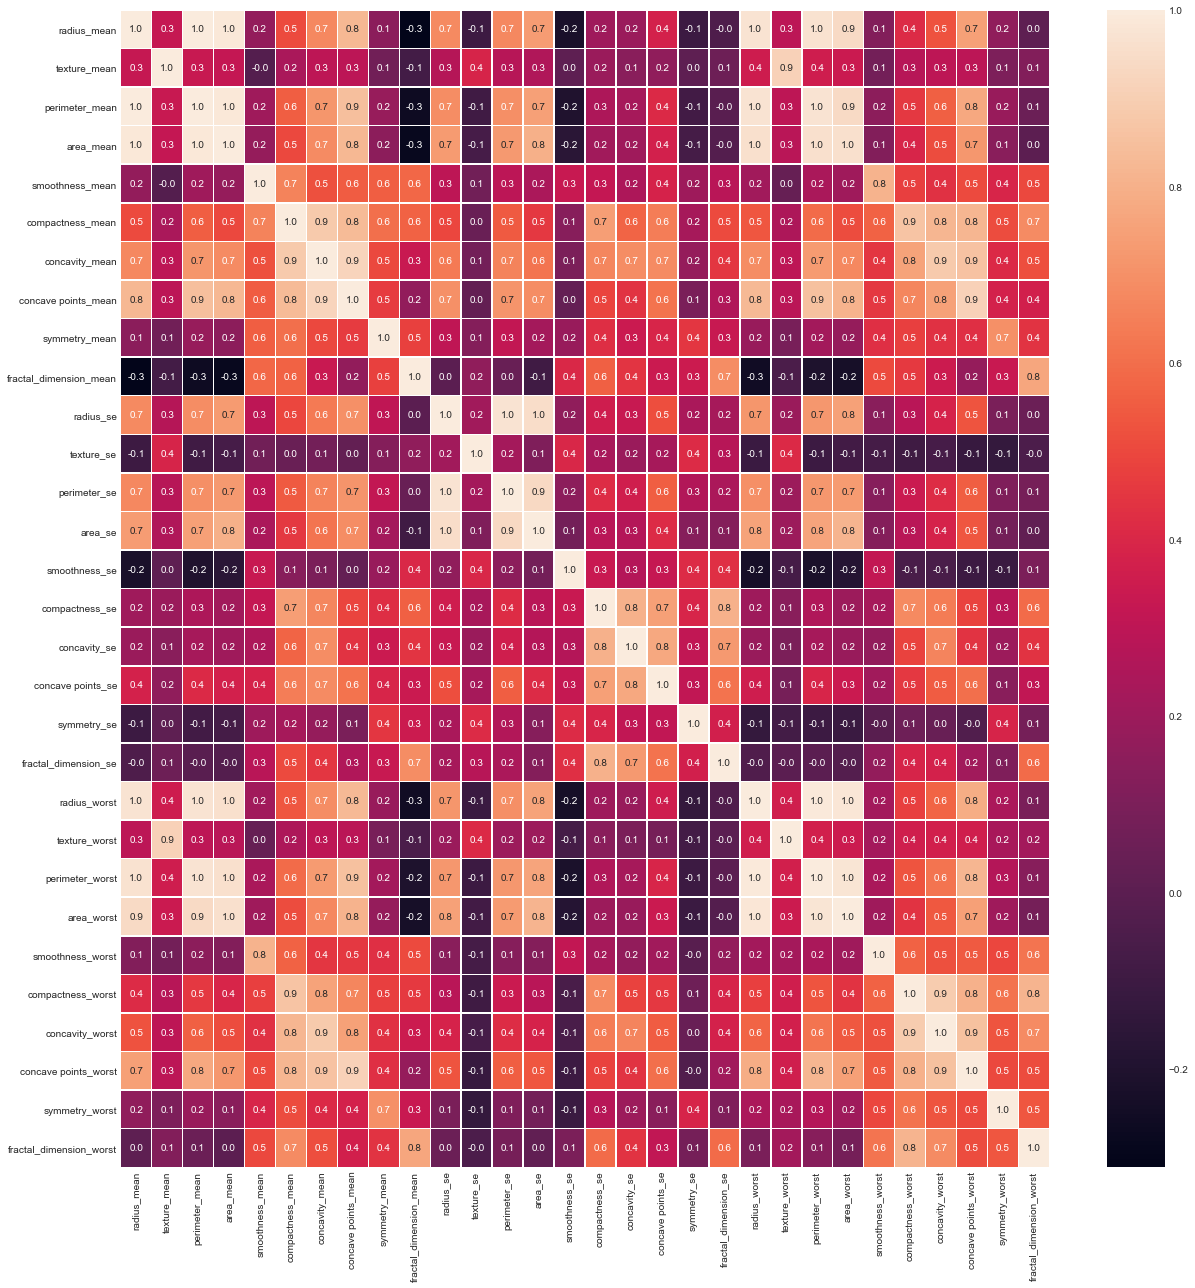

In [24]:
fig, ax = plt.subplots(figsize = (18, 18))
sns.heatmap(dfc.corr(), annot= True, linewidths=.5, fmt= '.1f', ax= ax);

In [25]:
dfc.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [26]:
# Drop correlated columns:
drop_cols_2 = ['perimeter_mean', 'radius_mean', 'compactness_mean', 'concave points_mean',
            'radius_se', 'perimeter_se', 'radius_worst', 'perimeter_worst',
            'compactness_worst', 'concave points_worst', 'texture_worst',
            'area_worst', 'compactness_se', 'concave points_se']

In [27]:
dfc = dfc.drop(columns= drop_cols_2)

In [28]:
dfc.shape

(569, 16)

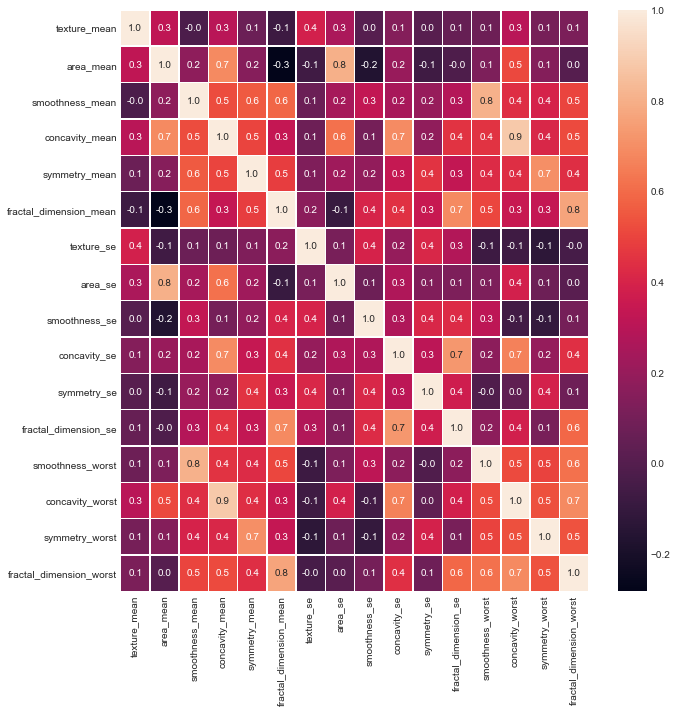

In [29]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(dfc.corr(), annot= True, linewidths=.5, fmt= '.1f', ax= ax);

### Splitting Data:

In [30]:
X_train, X_test, y_train, y_test = train_test_split(dfc, target, test_size = .3, random_state = 42)


### Model:

In [31]:
xgb.set_config(verbosity=0)

clf = xgb.XGBClassifier(random_state = 42)
clf = clf.fit(X_train, y_train);

In [32]:
preds = clf.predict(X_test)

In [33]:
print(f"Accuracy is: {accuracy_score(y_test, preds)}")

Accuracy is: 0.9766081871345029


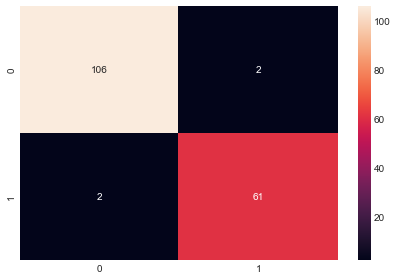

In [34]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot= True, fmt = 'd');

### Feature Selection:(Best Features)

In [35]:
selected_features = SelectKBest(chi2, k = 10).fit(X_train, y_train)
print("Score List:  ", selected_features.scores_)

Score List:   [6.06916433e+01 3.66899557e+04 1.00015175e-01 1.30547650e+01
 1.95982847e-01 3.42575072e-04 4.07131026e-02 6.12741067e+03
 1.32470372e-03 6.92896719e-01 1.39557806e-03 2.65927071e-03
 2.63226314e-01 2.58858117e+01 1.00635138e+00 1.23087347e-01]


In [36]:
X_train_2 = selected_features.transform(X_train)
X_test_2 = selected_features.transform(X_test)

In [37]:
clf_2 = xgb.XGBClassifier(random_state = 42).fit(X_train_2, y_train)

In [38]:
preds_2 = clf_2.predict(X_test_2)

In [39]:
print(f"Accuracy is: {accuracy_score(y_test, preds_2)}")

Accuracy is: 0.9824561403508771


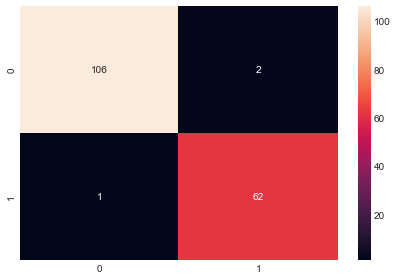

In [40]:
cm = confusion_matrix(y_test, preds_2)
sns.heatmap(cm, annot= True, fmt = 'd');

### Recursive Feature Elmination with Cross-Validdation

In [41]:
clf_3 = xgb.XGBClassifier()
rfecv = RFECV(estimator= clf_3, step = 1, cv = 5, scoring= 'accuracy', n_jobs= -1).fit(X_train, y_train)

In [42]:
print(f"Optimal Number of features: {rfecv.n_features_}")
print("Best Features: ", X_train.columns[rfecv.support_])

Optimal Number of features: 14
Best Features:  Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'texture_se', 'area_se', 'smoothness_se',
       'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'smoothness_worst', 'concavity_worst', 'symmetry_worst'],
      dtype='object')


In [43]:
preds_3 = rfecv.predict(X_test)

In [44]:
print(f"Accuracy is: {accuracy_score(y_test, preds_3)}")

Accuracy is: 0.9824561403508771


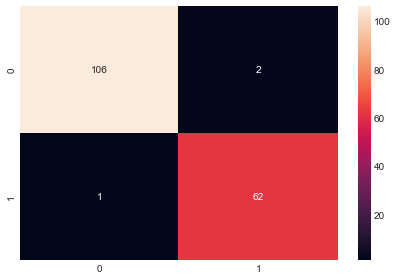

In [45]:
cm = confusion_matrix(y_test, preds_3)
sns.heatmap(cm, annot= True, fmt = 'd');

### Feature Extraction using Principal Component Analysis:

In [48]:
# we do this on the original data before dropping the correlated features:
X = df.drop(columns = drop_cols)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)


In [49]:
# Normalize Data:
X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
X_test_norm = (X_test - X_test.mean()) / (X_test.max() - X_test.min())

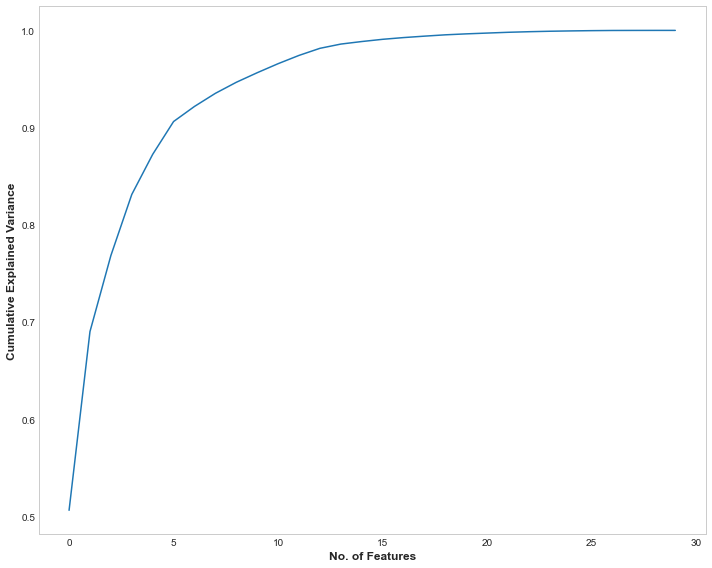

In [52]:
pca = PCA()
pca.fit(X_train_norm)

plt.figure(1, figsize= (10, 8))
sns.lineplot(data = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("No. of Features")
plt.ylabel("Cumulative Explained Variance");

In [60]:
pca =PCA(n_components= 14)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [61]:
clf_4 = xgb.XGBClassifier().fit(X_train_pca, y_train)

In [62]:
preds_4 = clf_4.predict(X_test_pca)

In [63]:
print(f"Accuracy is: {accuracy_score(y_test, preds_4)}")

Accuracy is: 0.9707602339181286


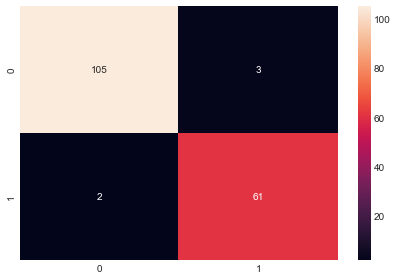

In [64]:
cm = confusion_matrix(y_test, preds_4)
sns.heatmap(cm, annot= True, fmt = 'd');